**Part 1:** In part 1, we explore compile the FOMC Minutes into a usable dataset and do preliminary EDA.

**Step 1:** We collect all the links for minutes from the Federal Reserve website.  Starting point is 1996.  Meeting minutes from prior to 2015 are in a different place to the more recent years. The FED seem to change the format of their minutes urls every few years, hence the extra if statement for 2007 through 2014. At the end of this block of code we've collected two lists. One is the links to minutes and the other is the meeting dates.

In [0]:
%%time
!pip install vaderSentiment
import matplotlib.pyplot as plt
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime
from functools import reduce
import pandas_datareader.data as data
import datetime
import matplotlib.dates as mdates

calendar_url = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'
recent_socket = urlopen(calendar_url)
recent_soup = BeautifulSoup(recent_socket, 'html.parser')

minutes = recent_soup.find_all('a', href=re.compile('^/monetarypolicy/fomcminutes\d{8}.htm'))
master_links = [minute.attrs['href'] for minute in minutes]

for year in range(2014, 1995, -1):
    year_url = "https://www.federalreserve.gov/monetarypolicy/fomchistorical%d.htm" % (year)
    year_socket = urlopen(year_url)
    year_soup = BeautifulSoup(year_socket, 'html.parser')
    if year > 2007:
        year_minutes = year_soup.find_all('a', href=re.compile('^/monetarypolicy/fomcminutes\d{8}.htm'))
    else:
        year_minutes = year_soup.find_all('a', href=re.compile('^/fomc/minutes/\d{8}.htm'))
    year_links = [year_minute.attrs['href'] for year_minute in year_minutes]
    master_links.extend(year_links)

temp_list = [re.match('(.*?).htm', x).group(1) for x in master_links]
date_list = [temp[-8:] for temp in temp_list]
#print(master_links)
#print(date_list)

CPU times: user 1.3 s, sys: 103 ms, total: 1.4 s
Wall time: 7.13 s


**Step 2:** Now we can loop through the list called `master_links` and scrape the minutes from each of these pages. We also create a more usable date format and some other derived columns.


In [0]:
%%time
df = pd.DataFrame(columns=['pydate', 'date', 'year', 'month', 'day', 'text', 'minute_length', 'retrieved_url'])

for i in range(len(master_links) - 1, 0, -1):
    url = 'https://www.federalreserve.gov' + master_links[i]
    res = requests.get(url)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    for script in soup(["script", "style"]):
        script.extract()
    text = soup.get_text()
    # break remove leading and trailing spaces in each line
    lines = (line.strip() for line in text.splitlines())
    blocks = (phrase.strip() for line in lines for phrase in line.split("  "))
    #removing blank lines and then placing all in one line
    text = '\n'.join(block for block in blocks if block)
    line = text.replace("\n", " ")
    df.loc[len(df)] = [datetime.datetime(int(date_list[i][:4]), int(date_list[i][4:6]), int(date_list[i][-2:])), date_list[i], int(date_list[i][:4]), int(date_list[i][5:6]), int(date_list[i][7:8]), line, len(line), url]

print(df.head())
df.to_json('fomc.json', orient='columns') #saving for storage or future use


      pydate  ...                                      retrieved_url
0 1996-12-17  ...  https://www.federalreserve.gov/fomc/minutes/19...
1 1996-11-13  ...  https://www.federalreserve.gov/fomc/minutes/19...
2 1996-09-24  ...  https://www.federalreserve.gov/fomc/minutes/19...
3 1996-08-20  ...  https://www.federalreserve.gov/fomc/minutes/19...
4 1996-07-02  ...  https://www.federalreserve.gov/fomc/minutes/19...

[5 rows x 8 columns]
CPU times: user 18.7 s, sys: 228 ms, total: 18.9 s
Wall time: 39.3 s


**Step 3:** In this step, we use VADER Sentiment Analysis library to get scores (positive, negative and neutral) based on the text of each meetings minutes. Sentiment Analysis of the minutes using the VADER SENTIMENT Analysis library

In [0]:
%%time
sid = SIA()
dfScores = pd.DataFrame()

for index, row in df.iterrows():
    scores = sid.polarity_scores(row['text'])
    dfTemp = pd.DataFrame.from_dict([scores])
    dfScores = dfScores.append(dfTemp)



CPU times: user 7min 48s, sys: 46.8 ms, total: 7min 48s
Wall time: 7min 48s


**Step 4:** We present summary statistics, in the form of the average sentiment per year as presented in Table 0.  Then we plot the negative and positve sentiment over time as shown in chart 0.

Table 0 - The Positive, Negative and Neutral Sentiment in FOMC Minutes (1990-2019)


,pos,neg,neu
year,,,
1996,0.108000,0.044375,0.847625
1997,0.114250,0.040000,0.846125
1998,0.111750,0.050125,0.838250
1999,0.114250,0.043500,0.842375
2000,0.117111,0.045000,0.838000
2001,0.107250,0.067500,0.825167
2002,0.116250,0.057000,0.826625
2003,0.111875,0.058250,0.830125
2004,0.117625,0.036875,0.845500


 
Chart 0 - The Positive and Negative Sentiment in FOMC Minutes (1996-2019)


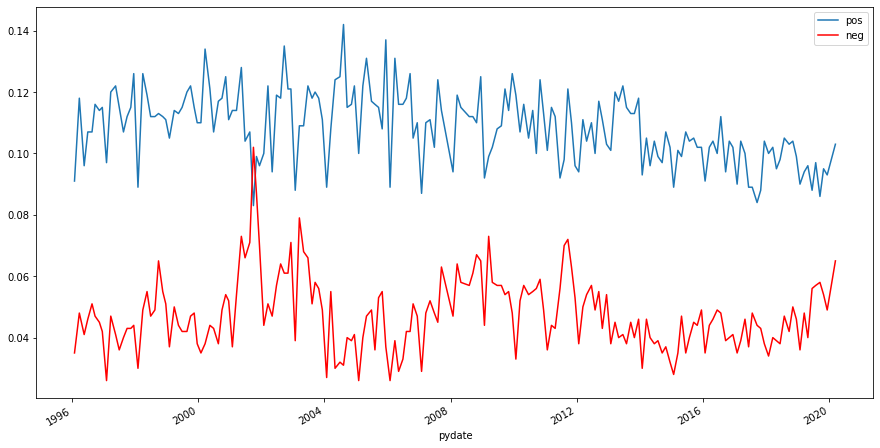

 
Chart 1 - The Length of text in FOMC Minutes (1996-2019)


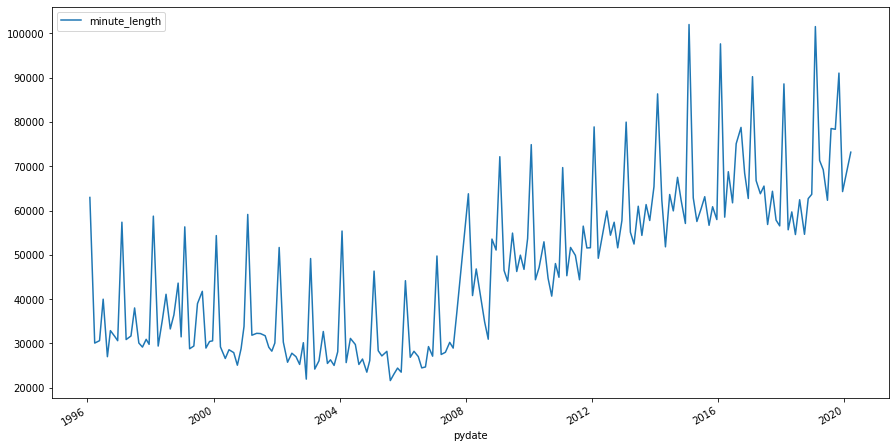

 
Chart 0a - The Positive Sentiment in FOMC Minutes (1996-2019) using 3rd Dimensional Polynomial Smoothing


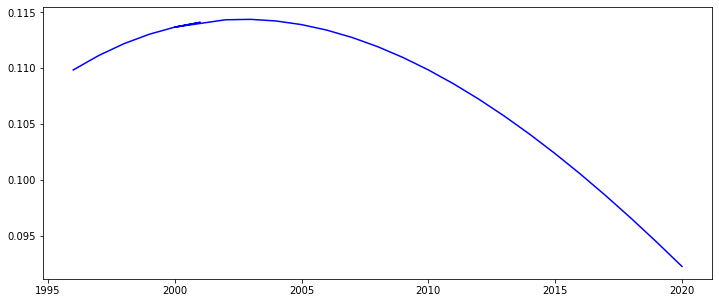

CPU times: user 576 ms, sys: 14.1 ms, total: 591 ms
Wall time: 587 ms


In [0]:
%%time
dfScores.reset_index(inplace = True, drop=True)

dfEDA = dfScores.merge(df, left_index=True, right_index=True)

dfTable0 = dfEDA[['year', 'pos', 'neg', 'neu']]
dfChart0 = dfEDA[['pydate', 'pos', 'neg', 'neu']]
dfChart1 = dfEDA[['pydate', 'minute_length']]
print("Table 0 - The Positive, Negative and Neutral Sentiment in FOMC Minutes (1990-2019)")

display(dfTable0.groupby('year').mean())



print(" ")
print("Chart 0 - The Positive and Negative Sentiment in FOMC Minutes (1996-2019)")

plt.figure(figsize=(15,8))
ax = plt.gca()

dfChart0.plot(kind='line',x='pydate',y='pos',ax=ax)
dfChart0.plot(kind='line',x='pydate',y='neg', color='red', ax=ax)

plt.show()

print(" ")
print("Chart 1 - The Length of text in FOMC Minutes (1996-2019)")

plt.figure(figsize=(15,8))
ax = plt.gca()

dfChart1.plot(kind='line',x='pydate',y='minute_length',ax=ax)

plt.show()

print(" ")
print("Chart 0a - The Positive Sentiment in FOMC Minutes (1996-2019) using 3rd Dimensional Polynomial Smoothing")

list_x = dfEDA['year'].tolist()
list_y0 = dfEDA['pos'].tolist()
list_y1 = dfEDA['neg'].tolist()
plt.figure(figsize=(12,5))


poly0 = np.polyfit(list_x,list_y0,3)
poly_y0 = np.poly1d(poly0)(list_x)
plt.plot(list_x,poly_y0,color='blue')
plt.show()






**Step 5:** Some Pearson Correlation coeffecients from comparing our sentiment scores to The National Employment Level, Job Openings Rate and Hires Rate for the US as a whole.

In [0]:
def get_bls_data(url, series, val):
    '''
    URL: parameter takes the end part of location of the web table from BLS website
    series: parameter takes the unique series code of a BLS data series
    val: parameter takes the name I want to give to a particular column
    '''
    global dfBLS
    dfBLS = pd.read_csv('https://download.bls.gov/pub/time.series/%s' % (url), sep='\t', header=0, low_memory=False)
    dfBLS = dfBLS[dfBLS['series_id        '].str.contains("%s" % (series))]
    dfBLS = dfBLS[~dfBLS.period.str.contains("Q")] # dropping Quarterly data if there is any
    dfBLS['month'] = dfBLS['period'].map(lambda x: x.lstrip('M')).astype(int)
    dfBLS['year'] = dfBLS['year'].astype(int)
    dfBLS['%s'  % (val)] = dfBLS['       value']
    dfBLS = dfBLS[['year','month','%s' % (val)]]

get_bls_data(url = "ce/ce.data.00a.TotalNonfarm.Employment", series = "CES0000000001", val ="emp")
dfCES = dfBLS
get_bls_data(url = "jt/jt.data.2.JobOpenings", series = "JTS00000000JOR", val ="openings" )
dfJO = dfBLS
get_bls_data(url = "jt/jt.data.3.Hires", series = "JTS00000000HIR", val ="hires")
dfHI = dfBLS

data_frame_list = [dfHI, dfJO, dfCES, dfEDA.drop(columns=['text'])]
dfMerged = reduce(lambda  left,right: pd.merge(left,right,on=['year', 'month'], how='outer'), data_frame_list)

pearsoncorr = dfMerged.corr(method='pearson')
display(pearsoncorr)

,year,month,hires,openings,emp,neg,neu,pos,compound
year,1.000000,-0.055470,-0.184756,0.617797,0.991332,-0.139079,0.388747,-0.450338,0.065930
month,-0.055470,1.000000,-0.003501,-0.030639,-0.022188,0.145869,-0.204509,0.157872,0.103913
hires,-0.184756,-0.003501,1.000000,0.595258,0.327919,-0.090163,0.055483,0.003198,-0.198186
openings,0.617797,-0.030639,0.595258,1.000000,0.905325,-0.262715,0.451135,-0.437824,-0.001380
emp,0.991332,-0.022188,0.327919,0.905325,1.000000,-0.092903,0.335049,-0.423974,0.082105
neg,-0.139079,0.145869,-0.090163,-0.262715,-0.092903,1.000000,-0.755862,0.103635,-0.327906
neu,0.388747,-0.204509,0.055483,0.451135,0.335049,-0.755862,1.000000,-0.729041,0.117911
pos,-0.450338,0.157872,0.003198,-0.437824,-0.423974,0.103635,-0.729041,1.000000,0.161594
compound,0.065930,0.103913,-0.198186,-0.001380,0.082105,-0.327906,0.117911,0.161594,1.000000


**Part 2:** In part two, we define our target variable for our model and begin an assessment of models.


**Step 1:** We create a target variable that reflects categorizes a recession based on several factors.  
First, is whether the National Bureau of Economic Research (NBER) categorizes a particular month/year as being part of a recession. Then we assess other factors the NBER uses to determine whether there is a recession or not.  NBER principally considers changes in GDP, the unemployment rate and the employment level as factors for determining a recession.
We will create two target variables using these data.  One will be on the same dates as the data and one will be offset to 18 months prior. The one set 18 months prior is used as a proxy for leading indication of a recession.  


 
Chart 2 - The Target Columns for Coincident and Lagging Recession (Annual Averages by year)


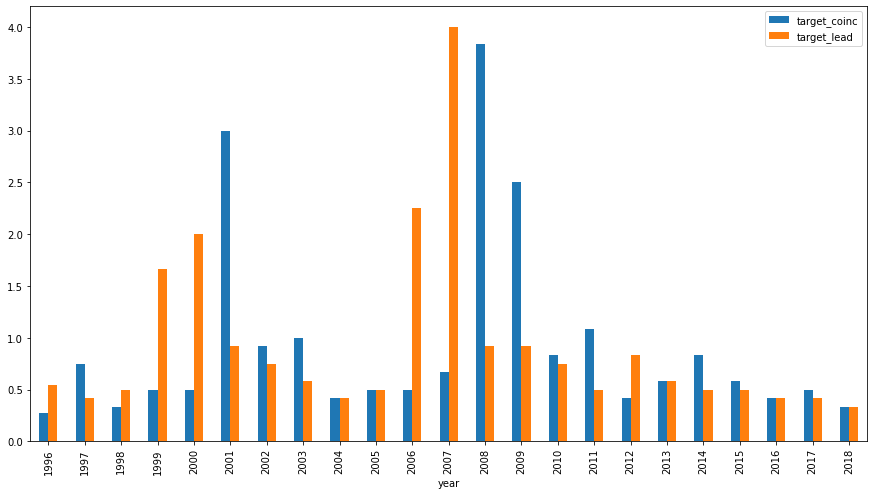

In [0]:
start = datetime.datetime(1996, 1, 1)
end = datetime.datetime(2019, 12, 1)

#US GDP Data (Quarterly being set to monthly)
dfgdp = data.DataReader("A191RL1Q225SBEA", "fred", start, end)
dfgdp['month'] = pd.DatetimeIndex(dfgdp.index).month
dfgdp['year'] = pd.DatetimeIndex(dfgdp.index).year
list_of_months = set(dfgdp['month'].to_list())
list_of_years = set(dfgdp['year'].to_list())
for yr in list_of_years:
  for mon in list_of_months:
    dfgdp.loc[datetime.datetime(yr, mon + 1, 1)] = [dfgdp.loc[datetime.datetime(yr, mon, 1)][0], mon + 1, yr]
    dfgdp.loc[datetime.datetime(yr, mon + 2, 1)] = [dfgdp.loc[datetime.datetime(yr, mon, 1)][0], mon + 2, yr]

dfgdp.sort_index(inplace=True)

#Number of employed persons in US
get_bls_data(url = "ce/ce.data.00a.TotalNonfarm.Employment", series = "CES0000000001", val ="emp")
dfCES = dfBLS
dfCES['day'] = 1
dfCES['DATE'] = pd.to_datetime(dfCES[['year', 'month', 'day']])
dfCES = dfCES.drop(columns=['year', 'month', 'day'])
dfCES = dfCES.set_index('DATE')
dfCES = dfCES.diff(axis = 0, periods = 1)

#Unemployment Rate
dfunr = data.DataReader("UNRATE", "fred", start, end)
dfunr = dfunr.diff(axis = 0, periods = 1)

#Bringing these 3 Dataframes into one
dfTargetVars = pd.concat([dfCES,dfunr,dfgdp], axis=1)
dfTargetVars = dfTargetVars[(dfTargetVars.index > start) & (dfTargetVars.index <= end)]

# Recession dates are based on NBER Recession Dates set by NBER Business Cycle Committee (NBER.org)
dfTargetVars['recession'] = 0
dfTargetVars['recession'][(dfTargetVars['year'] == 2001) & (dfTargetVars['month'].isin([3,4,5,6,7,8,9,10,11]))] = 2
dfTargetVars['recession'][((dfTargetVars['year'] == 2007) & (dfTargetVars['month'] == 12))] = 2
dfTargetVars['recession'][dfTargetVars['year'] == 2008] = 2
dfTargetVars['recession'][((dfTargetVars['year'] == 2009) & (dfTargetVars['month'].isin([1,2,3,4,5,6])))] = 2
dfTargetVars = dfTargetVars.drop(columns=['year', 'month'])

# Here I delop Binary Vaiables that are one if the the unemployment rate or gdp or employment
# went down from the previous month, otherwise they're 0.
dfTargetVars['urBIN'] = dfTargetVars['UNRATE'].apply(lambda x: 1 if x < 0 else 0)
dfTargetVars['gdpBIN'] = dfTargetVars['A191RL1Q225SBEA'].apply(lambda x: 1 if x < 0 else 0)
dfTargetVars['empBIN'] = dfTargetVars['emp'].apply(lambda x: 1 if x < 0 else 0)
dfTargetVars = dfTargetVars.drop(columns=['UNRATE', 'A191RL1Q225SBEA', 'emp'])

#Establishing two distinct datframes offset by 18 months
dfTargetVars['target'] = dfTargetVars.apply(lambda x: x.sum(), axis=1)
dfTargetVars['date_0'] = dfTargetVars.index  #coincident indicator date
dfTargetVars['date_1'] = dfTargetVars.index + pd.offsets.DateOffset(months=-18) #leading indicator date (18 months prior)

dfTargetLead = dfTargetVars[['date_1', 'target']]
dfTargetLead.index = dfTargetLead['date_1']
dfTargetLead = dfTargetLead.drop(columns=['date_1']).rename({'target': 'target_lead'}, axis=1) 

dfTargetCoinc = dfTargetVars[['date_0', 'target']]
dfTargetCoinc.index = dfTargetCoinc['date_0']
dfTargetCoinc = dfTargetCoinc.drop(columns=['date_0']).rename({'target': 'target_coinc'}, axis=1)

# Developing another dataframe to plot average of two target columns by year
dfTarget = dfTargetCoinc.join(dfTargetLead)
dfTarget = dfTarget.dropna()
dfTarget['target_lead'] = dfTarget['target_lead'].astype(int)
dfTarget['year'] = pd.DatetimeIndex(dfTarget.index).year

print(" ")
print("Chart 2 - The Target Columns for Coincident and Lagging Recession (Annual Averages by year)")

dfChart2 =  dfTarget.groupby('year').mean()

plt.figure(figsize=(15,8))
ax = plt.gca()

dfChart2.plot(kind='bar', ax=ax)

plt.show()



dfFinal = dfEDA[['pydate', 'pos', 'neg', 'neu']]
dfFinal['month'] = pd.DatetimeIndex(dfFinal['pydate']).month
dfFinal['year'] = pd.DatetimeIndex(dfFinal['pydate']).year

dfTargetLead['month'] = pd.DatetimeIndex(dfTargetLead.index).month
dfTargetLead['year'] = pd.DatetimeIndex(dfTargetLead.index).year

dfModelLead = dfFinal.merge(dfTargetLead, on=['year','month'])




**Step 2**: We've create 2 target variable that reflects categorizes a recession based on several factors.  We'll begin an analysis on the leading indicator of a recession first. 

To start with we'll assess at some Naive Bayes, K-nearest neighbors and logistic regression models for this classification problem.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, GradientBoostingClassifier, ExtraTreesClassifier

X = dfModelLead.drop(['pydate', 'month','year','target_lead'], axis=1) # removing the target column and dates
y = dfModelLead['target_lead']
#column_list = X.columns.get_values().tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

initial_results_df = pd.DataFrame(columns=['model / parameters', 'trainingImportance', 'testingImportance'])

modelDict = {GaussianNB(): "Gaussian Naive Bayes", 
             MultinomialNB(alpha=0.1): "MN Naive Bayes (alpha=0.1)",
             MultinomialNB(alpha=0.01): "MN Naive Bayes (alpha=0.01)", 
             KNeighborsClassifier(algorithm="brute"): "5-NN (brute)", 
             KNeighborsClassifier(algorithm="ball_tree"): "5-NN (ball-tree)", 
             LogisticRegression(solver='liblinear'): "Logistic Regression (c=1 - defult)",
		         LogisticRegression(solver='liblinear', C=100): "Logistic Regression - (c=100)",
             LogisticRegression(solver='liblinear', C=0.1): "Logistic Regression (c=0.1)",
		         LogisticRegression(solver='liblinear', C=1000): "Logistic Regression - (c=1000)",
		         LogisticRegression(solver='liblinear', C=0.0001): "Logistic Regression - (c=0.0001)",
             LogisticRegression(solver='liblinear', C=0.1): "Logistic Regression (c=0.1)",
		         LogisticRegression(solver='liblinear', C=0.001): "Logistic Regression - (c=0.001)",
		         LinearSVC(): "LinearSVC (c=1 - defult)",
             LinearSVC(C=0.1): "LinearSVC (c=0.1)",
		         LinearSVC(C=100): "LinearSVC (c=100)",}

for key, value in modelDict.items():
    model = key
    model.fit(X_train, y_train)
    print(value, " -Accuracy Score on Training Set: {:.3f}".format(model.score(X_train, y_train)))
    print(value, " -Accuracy Score on Test Set: {:.3f}".format(model.score(X_test, y_test)))
    initial_results_df.loc[len(initial_results_df)] = [value, model.score(X_train, y_train), model.score(X_test, y_test)]

print(" ")
print(" ")
print("Initial Classification Models --- Results Table")	
print(" ")
display(initial_results_df)



Gaussian Naive Bayes  -Accuracy Score on Training Set: 0.524
Gaussian Naive Bayes  -Accuracy Score on Test Set: 0.568
MN Naive Bayes (alpha=0.1)  -Accuracy Score on Training Set: 0.490
MN Naive Bayes (alpha=0.1)  -Accuracy Score on Test Set: 0.486
MN Naive Bayes (alpha=0.01)  -Accuracy Score on Training Set: 0.490
MN Naive Bayes (alpha=0.01)  -Accuracy Score on Test Set: 0.486
5-NN (brute)  -Accuracy Score on Training Set: 0.605
5-NN (brute)  -Accuracy Score on Test Set: 0.405
5-NN (ball-tree)  -Accuracy Score on Training Set: 0.619
5-NN (ball-tree)  -Accuracy Score on Test Set: 0.432
Logistic Regression (c=1 - defult)  -Accuracy Score on Training Set: 0.490
Logistic Regression (c=1 - defult)  -Accuracy Score on Test Set: 0.486
Logistic Regression - (c=100)  -Accuracy Score on Training Set: 0.497
Logistic Regression - (c=100)  -Accuracy Score on Test Set: 0.486
Logistic Regression (c=0.1)  -Accuracy Score on Training Set: 0.490
Logistic Regression (c=0.1)  -Accuracy Score on Test Set: 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,model / parameters,trainingImportance,testingImportance
0,Gaussian Naive Bayes,0.523810,0.567568
1,MN Naive Bayes (alpha=0.1),0.489796,0.486486
2,MN Naive Bayes (alpha=0.01),0.489796,0.486486
3,5-NN (brute),0.605442,0.405405
4,5-NN (ball-tree),0.619048,0.432432
5,Logistic Regression (c=1 - defult),0.489796,0.486486
6,Logistic Regression - (c=100),0.496599,0.486486
7,Logistic Regression (c=0.1),0.489796,0.486486
8,Logistic Regression - (c=1000),0.489796,0.567568
9,Logistic Regression - (c=0.0001),0.489796,0.486486


The results of the k=5 Nearest Nighbors provide some predictive power but we see some overfitting. For the Linear SVC and particularly the Logistic Regression models presented we don't see overfitting. A potential soltion to this would be to standardize the feature columns using sklearn.preprocessing.StandardScaler(). Now we'll examine two other classification models: Random Forest Classifiers and Gradient Boosting Classifier.

In [0]:
rf_results_df = pd.DataFrame(columns=['parameters', 'trainingImportance', 'testingImportance']) #making a results dataframe
#making a dictionary of RFClassifiers
rfDict = {RandomForestClassifier(n_estimators=100, random_state=1): "default parameters", 
          RandomForestClassifier(n_estimators=5, random_state=1): "n_estimators=5", 
		      RandomForestClassifier(n_estimators=5, max_depth=2, random_state=1): "n_estimators=5, max_depth=2",
          RandomForestClassifier(n_estimators=5, max_depth=8, random_state=1): "n_estimators=5, max_depth=8", 
		      RandomForestClassifier(n_estimators=5, max_depth=16, random_state=1): "n_estimators=5, max_depth=16",
		      RandomForestClassifier(n_estimators=10, random_state=1): "n_estimators=10, random_state=1", 
		      RandomForestClassifier(n_estimators=10,  max_depth=8, random_state=1): "n_estimators=10, max_depth=8",
          RandomForestClassifier(n_estimators=12, max_depth=8, random_state=1): "n_estimators=12, max_depth=8", 
		      RandomForestClassifier(n_estimators=100, max_depth=25, random_state=1): "n_estimators=100, max_depth=25"}
		  
print("************************************************************")
print("Random Forest Classification --- Results")
print(" ")
for key, value in rfDict.items():
    model = key
    model.fit(X_train, y_train)
    print("(%s)"  % (value), "Accuracy Score on Training Set: {:.3f}".format(model.score(X_train, y_train)))
    print("(%s)"  % (value), "Accuracy Score on Test Set: {:.3f}".format(model.score(X_test, y_test)))
    rf_results_df.loc[len(rf_results_df)] = [value,model.score(X_train, y_train), model.score(X_test, y_test)]

print(" ")
print(" ")
print("Random Forest Classification --- Results Table")	
print(" ")
display(rf_results_df)

************************************************************
Random Forest Classification --- Results
 
(default parameters) Accuracy Score on Training Set: 0.986
(default parameters) Accuracy Score on Test Set: 0.486
(n_estimators=5) Accuracy Score on Training Set: 0.918
(n_estimators=5) Accuracy Score on Test Set: 0.351
(n_estimators=5, max_depth=2) Accuracy Score on Training Set: 0.599
(n_estimators=5, max_depth=2) Accuracy Score on Test Set: 0.514
(n_estimators=5, max_depth=8) Accuracy Score on Training Set: 0.803
(n_estimators=5, max_depth=8) Accuracy Score on Test Set: 0.351
(n_estimators=5, max_depth=16) Accuracy Score on Training Set: 0.918
(n_estimators=5, max_depth=16) Accuracy Score on Test Set: 0.351
(n_estimators=10, random_state=1) Accuracy Score on Training Set: 0.939
(n_estimators=10, random_state=1) Accuracy Score on Test Set: 0.459
(n_estimators=10, max_depth=8) Accuracy Score on Training Set: 0.816
(n_estimators=10, max_depth=8) Accuracy Score on Test Set: 0.486
(n_e

,parameters,trainingImportance,testingImportance
0,default parameters,0.986395,0.486486
1,n_estimators=5,0.918367,0.351351
2,"n_estimators=5, max_depth=2",0.598639,0.513514
3,"n_estimators=5, max_depth=8",0.802721,0.351351
4,"n_estimators=5, max_depth=16",0.918367,0.351351
5,"n_estimators=10, random_state=1",0.938776,0.459459
6,"n_estimators=10, max_depth=8",0.816327,0.486486
7,"n_estimators=12, max_depth=8",0.843537,0.459459
8,"n_estimators=100, max_depth=25",0.986395,0.486486


In [0]:
gb_results_df = pd.DataFrame(columns=['parameters', 'trainingImportance', 'testingImportance'])
gfDict = {GradientBoostingClassifier(random_state=1): "default parameters", 
          GradientBoostingClassifier(random_state=1, learning_rate=0.01): "learning_rate=0.01", 
		      GradientBoostingClassifier(random_state=1, learning_rate=0.001): "learning_rate=0.001",
          GradientBoostingClassifier(random_state=1, max_depth=10): "max_depth=10", 
		      GradientBoostingClassifier(random_state=1, max_depth=5): "max_depth=5",
		      GradientBoostingClassifier(random_state=1, max_depth=10, learning_rate=0.01): "max_depth=10, learning_rate=0.01"}

print("************************************************************")
print("Gradient Boosting Classification --- Results")
print(" ")
for key, value in gfDict.items():
    model = key
    model.fit(X_train, y_train)
    print("(%s)"  % (value), "Accuracy Score on Training Set: {:.3f}".format(model.score(X_train, y_train)))
    print("(%s)"  % (value), "Accuracy Score on Test Set: {:.3f}".format(model.score(X_test, y_test)))
    gb_results_df.loc[len(gb_results_df)] = [value,model.score(X_train, y_train), model.score(X_test, y_test)]
	

print(" ")
print(" ")
print("Gradient Boosting Classification --- Results Table")	
print(" ")
display(gb_results_df)


************************************************************
Gradient Boosting Classification --- Results
 
(default parameters) Accuracy Score on Training Set: 0.980
(default parameters) Accuracy Score on Test Set: 0.459
(learning_rate=0.01) Accuracy Score on Training Set: 0.741
(learning_rate=0.01) Accuracy Score on Test Set: 0.405
(learning_rate=0.001) Accuracy Score on Training Set: 0.524
(learning_rate=0.001) Accuracy Score on Test Set: 0.486
(max_depth=10) Accuracy Score on Training Set: 0.986
(max_depth=10) Accuracy Score on Test Set: 0.405
(max_depth=5) Accuracy Score on Training Set: 0.986
(max_depth=5) Accuracy Score on Test Set: 0.405
(max_depth=10, learning_rate=0.01) Accuracy Score on Training Set: 0.973
(max_depth=10, learning_rate=0.01) Accuracy Score on Test Set: 0.405
 
 
Gradient Boosting Classification --- Results Table
 


,parameters,trainingImportance,testingImportance
0,default parameters,0.979592,0.459459
1,learning_rate=0.01,0.741497,0.405405
2,learning_rate=0.001,0.523810,0.486486
3,max_depth=10,0.986395,0.405405
4,max_depth=5,0.986395,0.405405
5,"max_depth=10, learning_rate=0.01",0.972789,0.405405


**Step 3:** Now I'm going to assess whether the Sentiment scores of the FOMC minutes can model a coincident indicator of a recession.  Same as last time and utilizing the same dictionaries,I'll look at some K-nearest neighbors and logistic regression and then progress to Random Forst and Gradient Boosting Classifiers.

In [0]:
dfTargetCoinc['month'] = pd.DatetimeIndex(dfTargetCoinc.index).month
dfTargetCoinc['year'] = pd.DatetimeIndex(dfTargetCoinc.index).year

dfModelCoinc = dfFinal.merge(dfTargetCoinc, on=['year','month'])


X = dfModelCoinc.drop(['pydate', 'month','year','target_coinc'], axis=1) # removing the target column and dates
y = dfModelCoinc['target_coinc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

initial_results_df = pd.DataFrame(columns=['model / parameters', 'trainingImportance', 'testingImportance'])

for key, value in modelDict.items():
    model = key
    model.fit(X_train, y_train)
    print(value, " -Accuracy Score on Training Set: {:.3f}".format(model.score(X_train, y_train)))
    print(value, " -Accuracy Score on Test Set: {:.3f}".format(model.score(X_test, y_test)))
    initial_results_df.loc[len(initial_results_df)] = [value, model.score(X_train, y_train), model.score(X_test, y_test)]

print(" ")
print(" ")
print("Initial Classification Models --- Results Table")	
print(" ")
display(initial_results_df)

Gaussian Naive Bayes  -Accuracy Score on Training Set: 0.468
Gaussian Naive Bayes  -Accuracy Score on Test Set: 0.462
MN Naive Bayes (alpha=0.1)  -Accuracy Score on Training Set: 0.436
MN Naive Bayes (alpha=0.1)  -Accuracy Score on Test Set: 0.487
MN Naive Bayes (alpha=0.01)  -Accuracy Score on Training Set: 0.436
MN Naive Bayes (alpha=0.01)  -Accuracy Score on Test Set: 0.487
5-NN (brute)  -Accuracy Score on Training Set: 0.577
5-NN (brute)  -Accuracy Score on Test Set: 0.564
5-NN (ball-tree)  -Accuracy Score on Training Set: 0.577
5-NN (ball-tree)  -Accuracy Score on Test Set: 0.513
Logistic Regression (c=1 - defult)  -Accuracy Score on Training Set: 0.436
Logistic Regression (c=1 - defult)  -Accuracy Score on Test Set: 0.487
Logistic Regression - (c=100)  -Accuracy Score on Training Set: 0.455
Logistic Regression - (c=100)  -Accuracy Score on Test Set: 0.462
Logistic Regression (c=0.1)  -Accuracy Score on Training Set: 0.436
Logistic Regression (c=0.1)  -Accuracy Score on Test Set: 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,model / parameters,trainingImportance,testingImportance
0,Gaussian Naive Bayes,0.467949,0.461538
1,MN Naive Bayes (alpha=0.1),0.435897,0.487179
2,MN Naive Bayes (alpha=0.01),0.435897,0.487179
3,5-NN (brute),0.576923,0.564103
4,5-NN (ball-tree),0.576923,0.512821
5,Logistic Regression (c=1 - defult),0.435897,0.487179
6,Logistic Regression - (c=100),0.455128,0.461538
7,Logistic Regression (c=0.1),0.435897,0.487179
8,Logistic Regression - (c=1000),0.442308,0.487179
9,Logistic Regression - (c=0.0001),0.435897,0.487179


There doesn't seem to be the overfitting that existed for the leading indicator of recession models.  However there still isn't great predictive power either.  Although K Nearest Neighbor Classification looks to provide some predictive power and performs equally well on the test data set.

We now examine RF and GB Classifiers as with the previous target variable.

In [0]:
print("************************************************************")
print("Random Forest Classification --- Results")
print(" ")
for key, value in rfDict.items():
    model = key
    model.fit(X_train, y_train)
    print("(%s)"  % (value), "Accuracy Score on Training Set: {:.3f}".format(model.score(X_train, y_train)))
    print("(%s)"  % (value), "Accuracy Score on Test Set: {:.3f}".format(model.score(X_test, y_test)))
    rf_results_df.loc[len(rf_results_df)] = [value,model.score(X_train, y_train), model.score(X_test, y_test)]
	
print(" ")
print(" ")
print("Random Forest Classification --- Results Table")	
print(" ")
display(rf_results_df)

************************************************************
Random Forest Classification --- Results
 
(default parameters) Accuracy Score on Training Set: 0.981
(default parameters) Accuracy Score on Test Set: 0.462
(n_estimators=5) Accuracy Score on Training Set: 0.917
(n_estimators=5) Accuracy Score on Test Set: 0.590
(n_estimators=5, max_depth=2) Accuracy Score on Training Set: 0.487
(n_estimators=5, max_depth=2) Accuracy Score on Test Set: 0.538
(n_estimators=5, max_depth=8) Accuracy Score on Training Set: 0.801
(n_estimators=5, max_depth=8) Accuracy Score on Test Set: 0.462
(n_estimators=5, max_depth=16) Accuracy Score on Training Set: 0.904
(n_estimators=5, max_depth=16) Accuracy Score on Test Set: 0.590
(n_estimators=10, random_state=1) Accuracy Score on Training Set: 0.936
(n_estimators=10, random_state=1) Accuracy Score on Test Set: 0.436
(n_estimators=10, max_depth=8) Accuracy Score on Training Set: 0.840
(n_estimators=10, max_depth=8) Accuracy Score on Test Set: 0.513
(n_e

,parameters,trainingImportance,testingImportance
0,default parameters,0.986395,0.486486
1,n_estimators=5,0.918367,0.351351
2,"n_estimators=5, max_depth=2",0.598639,0.513514
3,"n_estimators=5, max_depth=8",0.802721,0.351351
4,"n_estimators=5, max_depth=16",0.918367,0.351351
5,"n_estimators=10, random_state=1",0.938776,0.459459
6,"n_estimators=10, max_depth=8",0.816327,0.486486
7,"n_estimators=12, max_depth=8",0.843537,0.459459
8,"n_estimators=100, max_depth=25",0.986395,0.486486
9,default parameters,0.980769,0.461538


In [0]:
print("************************************************************")
print("Gradient Boosting Classification --- Results")
print(" ")
for key, value in gfDict.items():
    model = key
    model.fit(X_train, y_train)
    print("(%s)"  % (value), "Accuracy Score on Training Set: {:.3f}".format(model.score(X_train, y_train)))
    print("(%s)"  % (value), "Accuracy Score on Test Set: {:.3f}".format(model.score(X_test, y_test)))
    gb_results_df.loc[len(gb_results_df)] = [value,model.score(X_train, y_train), model.score(X_test, y_test)]
	
print(" ")
print(" ")
print("Gradient Boosting Classification --- Results Table")	
print(" ")
display(gb_results_df)

************************************************************
Gradient Boosting Classification --- Results
 
(default parameters) Accuracy Score on Training Set: 0.974
(default parameters) Accuracy Score on Test Set: 0.487
(learning_rate=0.01) Accuracy Score on Training Set: 0.782
(learning_rate=0.01) Accuracy Score on Test Set: 0.513
(learning_rate=0.001) Accuracy Score on Training Set: 0.500
(learning_rate=0.001) Accuracy Score on Test Set: 0.538
(max_depth=10) Accuracy Score on Training Set: 0.981
(max_depth=10) Accuracy Score on Test Set: 0.513
(max_depth=5) Accuracy Score on Training Set: 0.981
(max_depth=5) Accuracy Score on Test Set: 0.513
(max_depth=10, learning_rate=0.01) Accuracy Score on Training Set: 0.981
(max_depth=10, learning_rate=0.01) Accuracy Score on Test Set: 0.538
 
 
Gradient Boosting Classification --- Results Table
 


,parameters,trainingImportance,testingImportance
0,default parameters,0.979592,0.459459
1,learning_rate=0.01,0.741497,0.405405
2,learning_rate=0.001,0.523810,0.486486
3,max_depth=10,0.986395,0.405405
4,max_depth=5,0.986395,0.405405
5,"max_depth=10, learning_rate=0.01",0.972789,0.405405
6,default parameters,0.974359,0.487179
7,learning_rate=0.01,0.782051,0.512821
8,learning_rate=0.001,0.500000,0.538462
9,max_depth=10,0.980769,0.512821


**Part 3 - Exploring Some Alternatives**

1. Now we explore using a *Bagging Classifier* using Logistic Regression as the base classifiers.


In [0]:
from sklearn import model_selection 
from sklearn.ensemble import BaggingClassifier 


kfold = model_selection.KFold(n_splits = 10, 
                              random_state = 0) 
  
base_cls = KNeighborsClassifier() 
 
num_trees = 10
  
# bagging classifier 
model = BaggingClassifier(base_estimator = base_cls, 
                          n_estimators = num_trees, 
                          random_state = 0) 
  
results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold) 
print("Train Score :", results.mean()) 
results = model_selection.cross_val_score(model, X_test, y_test, cv = kfold)
print("Test Score :", results.mean())  

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Train Score : 0.4041666666666667
Test Score : 0.4166666666666667


2. Tested term frequency–inverse document frequency (Tfidf) instead of Vader Sentiment Analysis

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

dfFinal2 = df[['pydate', 'text']]
dfFinal2['month'] = pd.DatetimeIndex(dfFinal2['pydate']).month
dfFinal2['year'] = pd.DatetimeIndex(dfFinal2['pydate']).year

dfTargetLead['month'] = pd.DatetimeIndex(dfTargetLead.index).month
dfTargetLead['year'] = pd.DatetimeIndex(dfTargetLead.index).year

dfModelLead2 = dfFinal2.merge(dfTargetLead, on=['year','month'])

X_train, X_test, y_train, y_test = train_test_split(dfModelLead2['text'].values, 
                 dfModelLead2['target_lead'].values,        
                 test_size=0.2)

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None)

tfidf_df = pd.DataFrame(columns=['model / parameters', 'trainingImportance', 'testingImportance'])
lr = LogisticRegression()
model = Pipeline([('tfidf', tfidf_vectorizer), ('lr', lr)])
model.fit(X_train, y_train)

print(" -Accuracy Score on Training Set: {:.3f}".format(model.score(X_train, y_train)))
print(" -Accuracy Score on Test Set: {:.3f}".format(model.score(X_test, y_test)))

modelDict = {LogisticRegression(solver='liblinear'): "Logistic Regression (c=1 - defult)",
		         LogisticRegression(solver='liblinear', C=100): "Logistic Regression - (c=100)",
             LogisticRegression(solver='liblinear', C=0.1): "Logistic Regression (c=0.1)",
		         LogisticRegression(solver='liblinear', C=1000): "Logistic Regression - (c=1000)",
		         LogisticRegression(solver='liblinear', C=0.0001): "Logistic Regression - (c=0.0001)",
             LogisticRegression(solver='liblinear', C=0.1): "Logistic Regression (c=0.1)",
		         LogisticRegression(solver='liblinear', C=0.001): "Logistic Regression - (c=0.001)",}

for key, value in modelDict.items():
    lr = key
    model = Pipeline([('tfidf', tfidf_vectorizer), ('lr', lr)])
    model.fit(X_train, y_train)
    tfidf_df.loc[len(tfidf_df)] = [value, model.score(X_train, y_train), model.score(X_test, y_test)]

print(" ")
print(" ")
print("Logistic Regression Models --- Results Table (Tokenized)")	
print(" ")
display(tfidf_df)


 -Accuracy Score on Training Set: 0.469
 -Accuracy Score on Test Set: 0.568
 
 
Logistic Regression Models --- Results Table (Tokenized)
 


,model / parameters,trainingImportance,testingImportance
0,Logistic Regression (c=1 - defult),0.469388,0.567568
1,Logistic Regression - (c=100),0.482993,0.540541
2,Logistic Regression (c=0.1),0.469388,0.567568
3,Logistic Regression - (c=1000),0.551020,0.594595
4,Logistic Regression - (c=0.0001),0.469388,0.567568
5,Logistic Regression (c=0.1),0.469388,0.567568
6,Logistic Regression - (c=0.001),0.469388,0.567568


3. Tested using Countvectorizer() to convert a collection of text documents (FOMC Minutes) to a matrix of token counts and compared Naive Bayes Results to Naive Bayes Results using Vader Sentiment Scores.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


X_train, X_test, y_train, y_test = train_test_split(dfModelLead2['text'].values, 
                 dfModelLead2['target_lead'].values,        
                 test_size=0.2)

vect = CountVectorizer(max_features=1000, binary=True)

X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.fit_transform(X_test)


model = MultinomialNB()


trainlist = []
testlist = []
for i in range(1, 100):
    model.fit(X_train_vect, y_train)
    trainlist.append(model.score(X_train_vect, y_train))
    testlist.append(model.score(X_test_vect, y_test))

print(sum(trainlist)/len(trainlist))
print(sum(testlist)/len(testlist))


modelDict = {MultinomialNB(alpha=0.1): "MN Naive Bayes (alpha=0.1)",
             MultinomialNB(alpha=0.1, fit_prior=False): "MN Naive Bayes (alpha=0.1) / Fit_prior=false",
             MultinomialNB(alpha=0.1): "MN Naive Bayes (alpha=0.05)",
             MultinomialNB(alpha=0.1, fit_prior=False): "MN Naive Bayes (alpha=0.05) / Fit_prior=false",
             MultinomialNB(alpha=0.01): "MN Naive Bayes (alpha=0.01)",
             MultinomialNB(alpha=0.1, fit_prior=False): "MN Naive Bayes (alpha=0.01) / Fit_prior=false",}

for key, value in modelDict.items():
    model = key
    trainlist = []
    testlist = []
    for i in range(1, 10):
        model.fit(X_train_vect, y_train)
        trainlist.append(model.score(X_train_vect, y_train))
        testlist.append(model.score(X_test_vect, y_test))
    print(value, "Training Scrore:", sum(trainlist)/len(trainlist))
    print(value, "Test Scrore:", sum(testlist)/len(testlist))


0.7074829931972796
0.4594594594594596
MN Naive Bayes (alpha=0.1) Training Scrore: 0.8843537414965985
MN Naive Bayes (alpha=0.1) Test Scrore: 0.43243243243243246
MN Naive Bayes (alpha=0.1) / Fit_prior=false Training Scrore: 0.8639455782312925
MN Naive Bayes (alpha=0.1) / Fit_prior=false Test Scrore: 0.45945945945945954
MN Naive Bayes (alpha=0.05) Training Scrore: 0.8843537414965985
MN Naive Bayes (alpha=0.05) Test Scrore: 0.43243243243243246
MN Naive Bayes (alpha=0.05) / Fit_prior=false Training Scrore: 0.8639455782312925
MN Naive Bayes (alpha=0.05) / Fit_prior=false Test Scrore: 0.45945945945945954
MN Naive Bayes (alpha=0.01) Training Scrore: 0.8911564625850341
MN Naive Bayes (alpha=0.01) Test Scrore: 0.43243243243243246
MN Naive Bayes (alpha=0.01) / Fit_prior=false Training Scrore: 0.8639455782312925
MN Naive Bayes (alpha=0.01) / Fit_prior=false Test Scrore: 0.45945945945945954


4. Explore redefining this as a regression problem rather than a classification problem.  Can the sentiment scores from FOMC Minutes predict the Unemployment Rate or the Real GDP?

I explored some regression methods and a standardize the columns using sklearn.preprocessingStandardScaler().

Regression Model - Random Forest Regression

Using using sklearn.preprocessingStandardScaler() will use standard sclaing on the feature columns.  The Highest {R^2}  

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

dfunr = data.DataReader("UNRATE", "fred", start, end)
dfunr['month'] = pd.DatetimeIndex(dfunr.index).month
dfunr['year'] = pd.DatetimeIndex(dfunr.index).year
dfMerged = reduce(lambda  left,right: pd.merge(left,right,on=['year', 'month'], how='outer'), [dfEDA.drop(columns=['text','retrieved_url']), dfunr])

dfRegressionLead = dfMerged[['neg', 'neu', 'pos', 'UNRATE']]
dfRegressionLead = dfRegressionLead.dropna()


X = dfRegressionLead.iloc[:, 0:3].values
y = dfRegressionLead.iloc[:, 3].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

modelDict = {RandomForestRegressor(n_estimators=10, random_state=0): "RFR with n_estimators set to 10", 
             RandomForestRegressor(n_estimators=50, random_state=0): "RFR with n_estimators set to 50", 
             RandomForestRegressor(n_estimators=100, random_state=0): "RFR with n_estimators set to 100",
		         RandomForestRegressor(n_estimators=200, random_state=0): "RFR with n_estimators set to 200",}


sc = StandardScaler()  
X_train_sc = sc.fit_transform(X_train)  
X_test_sc = sc.transform(X_test) 

for key, value in modelDict.items():
    regressor = key
    regressor.fit(X_train_sc, y_train)  
    y_pred = regressor.predict(X_test_sc) 
    print('********** Results for : %s **********' % (value)) 
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('RSquared Value:', r2_score(y_test, y_pred))
    print('*******************************************************************************')


results_df = pd.DataFrame(columns=['Base Estim.', 'RMSE', 'R2', 'Params'])

def start_regressors():
    grid = ParameterGrid({"max_samples": [0.5, 1.0],
                          "max_features": [0.5, 1.0],
                          "bootstrap": [True, False],
                          "bootstrap_features": [True, False]})

    for base_estimator in [DecisionTreeRegressor(), KNeighborsRegressor(), SVR()]:
        for params in grid:
            y_pred = BaggingRegressor(base_estimator=base_estimator, random_state=0, **params).fit(X_train, y_train).predict(X_test) 
            results_df.loc[len(results_df)] = [base_estimator, np.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred), params]

start_regressors()
display(results_df)

********** Results for : RFR with n_estimators set to 10 **********
Mean Absolute Error: 1.3928378378378379
Mean Squared Error: 3.5478922297297304
Root Mean Squared Error: 1.8835849409383507
RSquared Value: 0.038372627641124035
*******************************************************************************
********** Results for : RFR with n_estimators set to 50 **********
Mean Absolute Error: 1.3525639639639644
Mean Squared Error: 3.3520237026426445
Root Mean Squared Error: 1.830853271740432
RSquared Value: 0.09146120103471489
*******************************************************************************
********** Results for : RFR with n_estimators set to 100 **********
Mean Absolute Error: 1.346309009009009
Mean Squared Error: 3.3329136607957968
Root Mean Squared Error: 1.8256269226750017
RSquared Value: 0.09664082266269547
*******************************************************************************
********** Results for : RFR with n_estimators set to 200 **********
Mean Absol

,Base Estim.,RMSE,R2,Params
0,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",2.067302,-0.158361,"{'bootstrap': True, 'bootstrap_features': True..."
1,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",2.167777,-0.273695,"{'bootstrap': True, 'bootstrap_features': True..."
2,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",1.881192,0.040815,"{'bootstrap': True, 'bootstrap_features': True..."
3,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",1.962958,-0.044380,"{'bootstrap': True, 'bootstrap_features': True..."
4,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",1.922633,-0.001911,"{'bootstrap': True, 'bootstrap_features': Fals..."
5,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",1.918721,0.002162,"{'bootstrap': True, 'bootstrap_features': Fals..."
6,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",1.872996,0.049154,"{'bootstrap': True, 'bootstrap_features': Fals..."
7,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",1.888871,0.032967,"{'bootstrap': True, 'bootstrap_features': Fals..."
8,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",2.024289,-0.110661,"{'bootstrap': False, 'bootstrap_features': Tru..."
9,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",2.122099,-0.220584,"{'bootstrap': False, 'bootstrap_features': Tru..."
